In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

#Import Libraries
import tensorflow as tf
import numpy as np
import math
import os
import matplotlib
import matplotlib.pyplot as plt
import datetime
import time

import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model

from sklearn.metrics import recall_score, precision_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from models import save_model, generate_model_CNN, plot_performance
from generators import generator, decode

/Users/astasik/anaconda3/envs/machine/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
save_dir = 'plots'
if not os.path.exists(save_dir):
        os.makedirs(save_dir)

X_train = np.load('../data/final_data/X_train.npy')
Y_train = np.load('../data/final_data/y_train.npy')


X_test = np.load('../data/final_data/X_test.npy')
Y_test = np.load('../data/final_data/y_test.npy')


X = np.load('../data/final_data/X.npy')
Y = np.load('../data/final_data/y.npy')

enc = OneHotEncoder(categories='auto')
Y = enc.fit_transform(Y.reshape(-1, 1) ,).toarray()

In [3]:
Y

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [4]:
batch_size = 500
time_window = X_test.shape[1]
n_dim = X_test.shape[2]
predict_early = 0

input_shape = (time_window, n_dim)

In [5]:
model = generate_model_CNN(input_shape)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 524, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 524, 20)           160       
_________________________________________________________________
average_pooling1d_1 (Average (None, 262, 20)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 262, 20)           80        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 262, 20)           2820      
_________________________________________________________________
average_pooling1d_2 (Average (None, 131, 20)           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 131, 20)           80        
__________

In [6]:
history = model.fit(X, Y,
                    batch_size=100,
                    epochs=100, 
                    verbose=1,
                    validation_split = 0.5,
                    validation_data = (X, Y),
                    )

save_model(model, name=predict_early)

Train on 1569 samples, validate on 1569 samples
Epoch 1/100
1569/1569 [==============================] - 6s 4ms/step - loss: 0.6360 - acc: 0.6909 - val_loss: 11.1358 - val_acc: 0.3091
Epoch 2/100
1569/1569 [==============================] - 2s 2ms/step - loss: 0.6219 - acc: 0.6909 - val_loss: 11.1358 - val_acc: 0.3091
Epoch 3/100
1569/1569 [==============================] - 3s 2ms/step - loss: 0.6201 - acc: 0.6909 - val_loss: 11.1358 - val_acc: 0.3091
Epoch 4/100
1569/1569 [==============================] - 3s 2ms/step - loss: 0.6226 - acc: 0.6909 - val_loss: 11.1358 - val_acc: 0.3091
Epoch 5/100
1569/1569 [==============================] - 3s 2ms/step - loss: 0.6199 - acc: 0.6909 - val_loss: 10.9324 - val_acc: 0.3091
Epoch 6/100
1569/1569 [==============================] - 3s 2ms/step - loss: 0.6194 - acc: 0.6909 - val_loss: 11.1358 - val_acc: 0.3091
Epoch 7/100
1569/1569 [==============================] - 4s 2ms/step - loss: 0.6193 - acc: 0.6909 - val_loss: 1.0417 - val_acc: 0.6909
E

Epoch 61/100
1569/1569 [==============================] - 3s 2ms/step - loss: 0.6193 - acc: 0.6909 - val_loss: 0.6699 - val_acc: 0.6909
Epoch 62/100
1569/1569 [==============================] - 2s 2ms/step - loss: 0.6195 - acc: 0.6909 - val_loss: 0.6943 - val_acc: 0.3091
Epoch 63/100
1569/1569 [==============================] - 2s 2ms/step - loss: 0.6186 - acc: 0.6909 - val_loss: 0.8813 - val_acc: 0.3091
Epoch 64/100
1569/1569 [==============================] - 3s 2ms/step - loss: 0.6186 - acc: 0.6909 - val_loss: 0.7034 - val_acc: 0.3091
Epoch 65/100
1569/1569 [==============================] - 2s 2ms/step - loss: 0.6187 - acc: 0.6909 - val_loss: 0.6533 - val_acc: 0.6909
Epoch 66/100
1569/1569 [==============================] - 2s 2ms/step - loss: 0.6187 - acc: 0.6909 - val_loss: 0.6449 - val_acc: 0.6909
Epoch 67/100
1569/1569 [==============================] - 2s 1ms/step - loss: 0.6192 - acc: 0.6909 - val_loss: 0.6411 - val_acc: 0.6909
Epoch 68/100
1569/1569 [========================

<IPython.core.display.Javascript object>


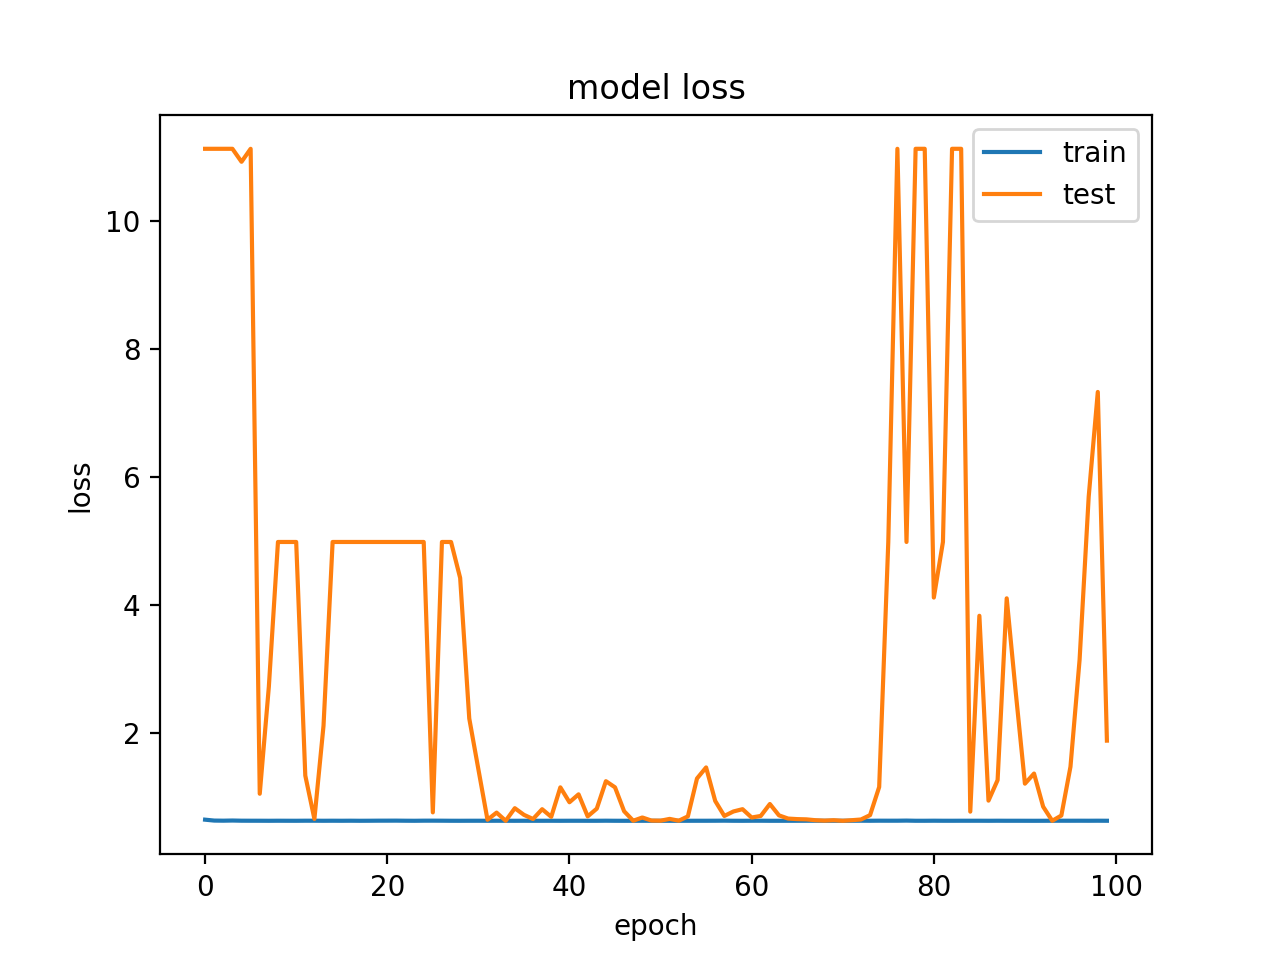

<IPython.core.display.Javascript object>


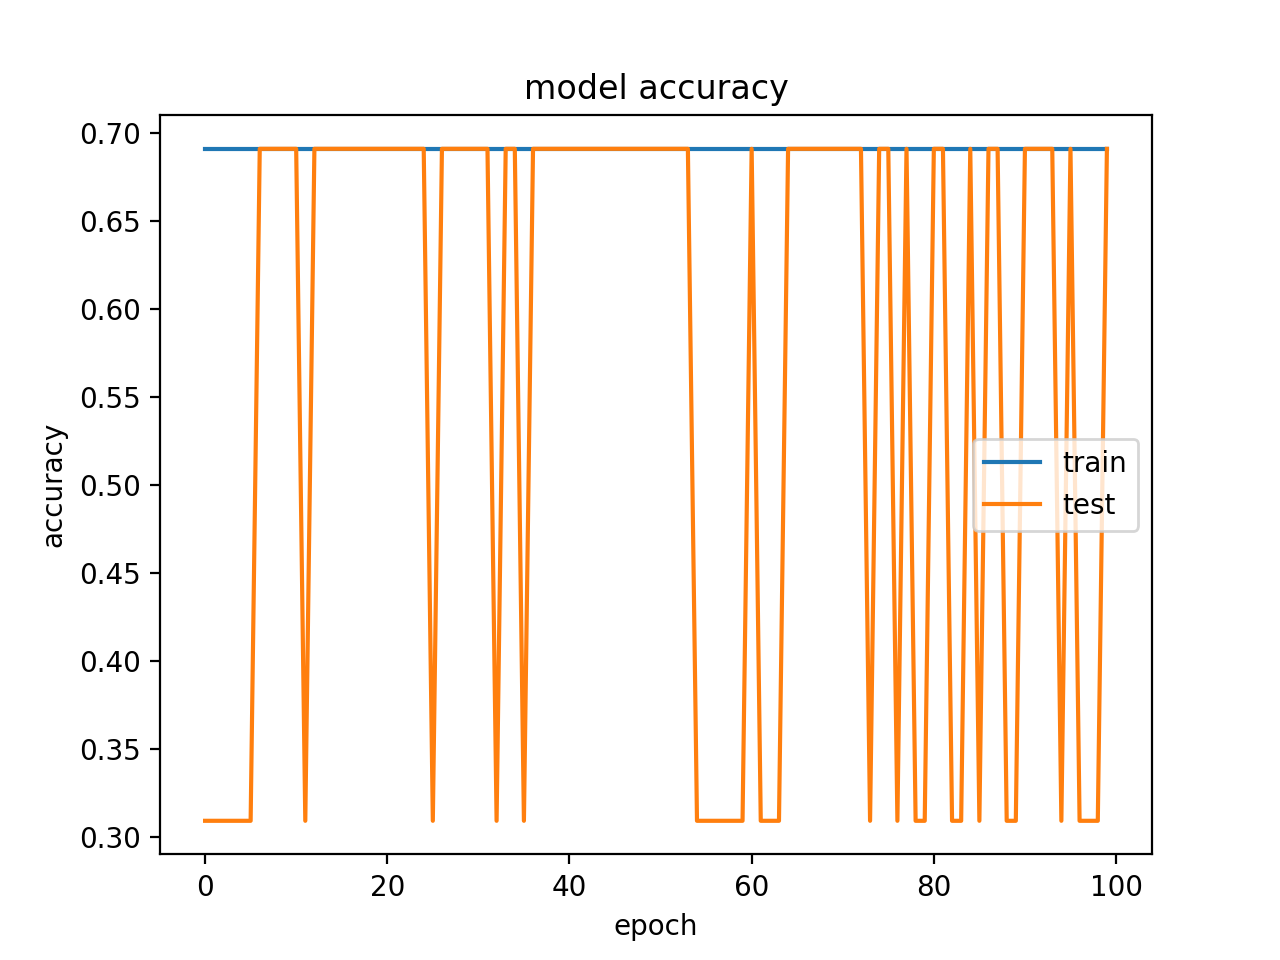

In [7]:
plot_performance(history)